# 海量图像训练预处理
by [@mingge](mingge_deng@brown.edu)<br>

### TensorFlow 系统概述与IO瓶颈

![alt text](tensorflow_system.png "TensorFlow System") 

1. Client
2. Distributed Master
3. Worker Service

<b>For a Real problem, IO is always the bottleneck!!!</b>

### TensorFlow 数据IO的三种方式


<b>Freload data: constant</b>

 数据直接嵌入graph， 由graph传入session中运行

In [11]:
import tensorflow as tf

x = tf.constant([1,2,3], name='x')
y = tf.constant([2,3,4], name='y')
z = tf.add(x,y, name='z')
with tf.Session() as sess:
    print(sess.run(z))

[3 5 7]


<b>Feeding: placeholder, feed_dict</b>

由占位符代替数据，运行时填入数据

In [12]:
import tensorflow as tf

x = tf.placeholder(tf.int16)
y = tf.placeholder(tf.int16)
z = tf.add(x,y, name='z')

with tf.Session() as sess:
    xs = [1,2,3]
    ys = [2,3,4]
    print(sess.run(z, feed_dict={x: xs, y: ys}))

[3 5 7]


Pipeline: XXXReader, Queue

Queue机制：
1. producer-consumer pattern(生产消费模式)
2. 独立于主线程执行
3. 异步IO: reader.read(queue)  tf.train.batch()

tf.TextLineReader()

tf.WholeFileReader()

tf.TFRecordReader()

![alt text](file_queue.gif "File Queue") 

In [ ]:
import tensorflow as tf

filenames = tf.train.match_filenames_once('.\data\*.csv')  #得到的是文件名str
filename_queue = tf.train.string_input_producer(filenames, shuffle=False, num_epochs=3)

reader = tf.TextLineReader()
_, value = reader.read(filename_queue)

example, label = tf.decode_csv(value, record_defaults=[['null'], ['null']])
## tf.train.shuffle_batch
## example_batch, label_batch = tf.train.batch([exmaple, label], batch_size=5, capacity=3*batch_size)

## record_list = [ tf.decode_csv(value, record_defaults=[['null'], ['null']]) for _ in range(2)]
## example_batch, label_batch = tf.train.batch_join(record_list, batch_size=5)


init_op = tf.local_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator() #线程管理协调器
    threads = tf.train.start_queue_runners(coord=coord) #启动QueueRunner
    """
    try:
        while not coord.should_stop():
            print(sess.run([example, label]))
    except tf.errors.OutOfRangeError:
        print('Epochs complete!')
    finally:
        coord.request_stop()
    """
    for _ in range(5):
        print(sess.run([example, label]))

    coord.request_stop()
    coord.join(threads)


### TensorFlow 数据统一数据输入格式TFRecord

why tfrecord, why not csv, jpg, png etc. ?

<b>1. 统一不同输入文件的框架</b>

<b>2. 节约空间（TFRecord压缩的二进制文件, protocal buffer序列化）</b>

```c++
message Example {
  Features features = 1;
};

message Features {
  map<string, Feature> feature = 1;
};

message Feature {
  oneof kind {
    BytesList bytes_list = 1;
    FloatList float_list = 2;
    Int64List int64_list = 3;
  }
};

```

#### 原始数据转为TFRecord存储

In [41]:
## convert csv files to tfrecord
import tensorflow as tf
import numpy as np
import pandas as pd

train_frame = pd.read_csv("train.csv")
print(train_frame.head())
train_labels_frame = train_frame.pop(item="label")
train_values = train_frame.values
train_labels = train_labels_frame.values
print("values shape: ", train_values.shape)
print("labels shape:", train_labels.shape)

writer = tf.python_io.TFRecordWriter("csv_train.tfrecords")

for i in range(train_values.shape[0]):
    image_raw = train_values[i].tostring()
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                "image_raw": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_raw])),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[train_labels[i]]))
            }
        )
    )
    writer.write(record=example.SerializeToString())
    
writer.close()

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         

In [ ]:
### convert pics to tfrecord
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import pandas as pd

def get_label_from_filename(filename):
    return 1

filenames = tf.train.match_filenames_once('.\data\*.png')

writer = tf.python_io.TFRecordWriter('png_train.tfrecords')

for filename in filenames:
    img=mpimg.imread(filename)
    print("{} shape is {}".format(filename, img.shape))
    img_raw = img.tostring()
    label = get_label_from_filename(filename)
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                "image_raw": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_raw])),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
        )
    )
    writer.write(record=example.SerializeToString())
    
writer.close()

#### TFRecord数据读取|

In [ ]:
import tensorflow as tf

reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer(["csv_train.tfrecords"])

_, serialized_record = reader.read(filename_queue)

features = tf.parse_single_example(
    serialized_record,
    features={
        ## tf.FixedLenFeature return Tensor
        ## tf.VarLenFeature return SparseTensor
        "image_raw": tf.FixedLenFeature([], tf.string),
        "label": tf.FixedLenFeature([], tf.int64),
    })

images = tf.decode_raw(features["image_raw"], tf.uint8)
labels = tf.cast(features["label"], tf.int32)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    for i in range(10):
        image, label = sess.run([images, labels])


### TensorFlow 图像处理函数

 #### encode/decode jpeg 和 png格式图像，i.e.，压缩或者还原为三维矩阵

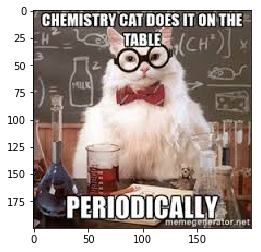

In [64]:
import matplotlib.pyplot as plt
import tensorflow as tf

image_raw = tf.gfile.FastGFile("cat.jpg", "rb").read()
# img_data = tf.image.decode_png(image_raw)
img_data = tf.image.decode_jpeg(image_raw)
#img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)
encoded_image = tf.image.encode_jpeg(img_data)
    
with tf.Session() as sess:
    plt.imshow(sess.run(img_data))
    plt.show()

    with tf.gfile.GFile("cat_float.jpeg","wb") as f:
        f.write(sess.run(encoded_image))
    

 #### 调整图像：To get a more robust model

In [ ]:
# resized: method = {0:bilinear, 1:nearest neighbor, 2:Bicubic 3: Area}
resized_img = tf.image.resize_images(img_data, 300, 300, method=0)

# crop or pad
croped_or_padded = tf.image.resize_image_with_crop_or_pad(img_data, 2000, 2000)
central_cropped = tf.image.central_crop(img_data, 0.5)

# flipped
flipped = tf.image.flip_up_down(img_data)
flipped = tf.image.flip_left_right(img_data)
transposed = tf.image.transpose_image(img_data)
flipped = tf.image.random_flip_up_down(img_data)

# adjust brightness
adjusted = tf.image.adjust_brightness(img_data, -0.5)
adjusted = tf.image.adjust_brightness(img_data, 0.5)
adjusted = tf.image.random_brightness(img_data, 0.5)

# adjust constrast
adjusted = tf.image.adjust_contrast(img_data, -5)
adjusted = tf.image.adjust_contrast(img_data, 5)
adjusted = tf.image.random_contrast(img_data, 1, 10)

# adjust_hue, adjust_saturation etc..

# standarize : mean=0, stddev=1
adjusted = tf.image.per_image_whitening(img_data)

# bounding_boxes

batched = tf.expand_dims(
    tf.image.convert_image_dtype(img_data, tf.float32), 0)
boxes = tf.constant([[0.05, 0.05, 0.9, 0.7], [0.35,0.47,0.5,0.9]])
result = tf.image.draw_bounding_boxes(batched, boxes)

